# Projet MCS :  Détection d'activité humaine - DTW et classification avec réduction de dimension

**Nom du Groupe :** 

**Noms :** BERQUEZ CATHALA 

**Prénoms :** Léa Victor 



Dans ce projet, nous essaierons de prédire l'activité humaine (1-Descendre, 2-Courir, 3-Assis, 4-Debout, 5-Monter ou 6-Marcher) en utilisant les capteurs du smartphone. C'est-à-dire qu'en utilisant les méthodes suivantes, le smartphone peut détecter ce que nous faisons en ce moment.


En utilisant l'accéléromètre  intégré dans le smartphone,  l'accélération linéaire 3-axes à un taux constant de 50Hz ont été relevées. Les expériences ont été enregistrées sur vidéo pour étiqueter les données manuellement. 

<img src="files/HARDataset.JPG" width="800" height="600"  >

Il est fourni pour chaque enregistrement de l'ensemble de données : 
- L'accélération triaxiale de l'accéléromètre (accélération totale) et l'accélération estimée du corps. 
- Son étiquette d'activité. 
- Un identifiant du sujet qui a réalisé l'expérience.


Ces 5 séances se décomposent en 4 parties : 
- Partie I : DTW et application du TD
- Partie II : Système de reconnaissance d'activité physique avec la DTW
- Partie III : Comparaison de la programmation dynamique avec une méthode de classification après prétraitement des données par ACP
- Partie IV : Votre étude

**Travail à rendre**

Pour cela, vous devez par binômes (effectif **OBLIGATOIRE**):
1. Implémenter la DTW, tester les exercices de TD;
3. Utilser la DTW pour créer un système de reconnaissance;
4. Evaluer les résultats en utilisant la matrice de confusion et le pourcentage de bonne classification;
5. Implémenter l'ACP et les kppv 
6. Rédiger un rapport en pdf présentant votre étude : les résultats par les 2 méthodes et vos commentaires et conclusions sur une étude plus générale en modifiant les tailles des ensembles de test et d'apprentissage, en changeant le nombre de classes  (Longeur max. : 10 pages).


**Dataset et description :**
https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+





In [254]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import math
from scipy import stats
import seaborn as sns

In [255]:
# Paramètres du dataset
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]

DATA_PATH = './WISDM_ar_v1.1_raw.txt'


# Durée des profils temporels
TIME_STEP = 60

# Paramètres
N_CLASSES = 6
N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration
SEGMENT_TIME_SIZE = 30
TAILLE_TEST=10
TAILLE_APP=30

## 1. Chargement des données d'apprentissage et de test

In [256]:

# Chargement
data = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
data['z-axis'].replace({';': ''}, regex=True, inplace=True)
data = data.dropna()

# DATA PREPROCESSING
data_convoluted = []
labels = []

def base (nbClasses, segmentTimeSize, timeStep, nbFeatures, tailleTest, tailleApp): 
    
    # DATA PREPROCESSING
    data_convoluted = []
    labels = []

    # Prendre des segments temporels de taille segmentTimeSize 
    # tous les timeStep pour une même activité
    # print('data shape : ', data.shape)
    for j in range(0,nbClasses):
        DataBest=data[data['activity'] == LABELS[j]]
        for i in range(0, len(DataBest) - segmentTimeSize, timeStep):
            x = DataBest['x-axis'].values[i: i + segmentTimeSize]
            y = DataBest['y-axis'].values[i: i + segmentTimeSize]
            z = DataBest['z-axis'].values[i: i + segmentTimeSize]
            data_convoluted.append([x, y, z])
            # Label de l'activité associé à chaque segment
            label = j
            labels.append(label)
        
    # Conversion numpy
    data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)
    labels = np.asarray(labels, dtype=np.int)
    #print("Convoluted data shape: ", data_convoluted.shape)
    #print("Labels shape:", labels.shape)

    #fig, axs = plt.subplots(nbClasses,figsize=(30,30))
    #fig.suptitle('Profil moyen Activité')

    profil_moyen=np.zeros((nbClasses,segmentTimeSize, nbFeatures))
    List_Data_Test=np.zeros(nbClasses*tailleTest)
    Data_Test=np.zeros((nbClasses*tailleTest,segmentTimeSize*nbFeatures))
    Data_App=np.zeros((tailleApp*nbClasses,segmentTimeSize*nbFeatures))
    Label_Test=np.zeros(nbClasses*tailleTest)
    Label_App=np.zeros(nbClasses*tailleApp)
    
    for i in range(nbClasses):
    # Selection des données correspondant à la classe i
        #print('Classe N°',i)
        res=np.where(labels==i)
        res=np.array(res)
        res=np.ravel(res)
        taille=res.shape[0]
    
        # Création de la base de Test par tirage aléatoire sur les 
        # profils temporels
        tirage=np.random.randint(0,taille,tailleTest)
        List_Data_Test[i*tailleTest:(i+1)*tailleTest]=res[tirage[0:tailleTest]]
        Label_Test[i*tailleTest:(i+1)*tailleTest]=i
        tir_dataTest=data_convoluted[res[tirage[0:tailleTest]],:,:]
        Data_Test[i*tailleTest:(i+1)*tailleTest,:]=np.reshape(tir_dataTest,(tailleTest,segmentTimeSize*nbFeatures))


        # Création de la base d'Apprentissage par tirage aléatoire sur les 
        # profils temporels
        tirage1=np.random.randint(0,taille,tailleApp)
        tir_dataApp=data_convoluted[res[tirage1[0:tailleApp]],:,:]
        Data_App[i*tailleApp:(i+1)*tailleApp,:]=np.reshape(tir_dataApp,(tailleApp,segmentTimeSize*nbFeatures))
        Label_App[i*tailleApp:(i+1)*tailleApp]=i
    
            # Affichage du profil temporel median de la classe 
        class1=np.median(tir_dataApp,axis=0)
        profil_moyen[i,:,:]=class1
        #axs[i].plot(range(segmentTimeSize),class1[:,0],'b--')
        #axs[i].plot(range(segmentTimeSize),class1[:,1],'r-')
        #axs[i].plot(range(segmentTimeSize),class1[:,2],'k.')
        #axs[i].set_ylabel('X-Y-Z acceleration (dg)',fontsize=20)
        #axs[i].set_title(LABELS[i], fontsize=20)

    #print("tir_dataApp.shape : \n", tir_dataApp.shape)
    #print("dataApp.shape : \n", Data_App.shape)
    #print("tir_dataApp : \n", tir_dataApp)
    #print("dataApp : \n", Data_App)
    #print("dataApp[0] : \n", Data_App[0])
    
    return Label_App, Data_Test, Data_App, data_convoluted, profil_moyen, List_Data_Test, Label_Test, labels 



In [257]:
Label_App, Data_Test, Data_App, data_convoluted, profil_moyen, List_Data_Test, Label_Test, labels = base(N_CLASSES, SEGMENT_TIME_SIZE, TIME_STEP, N_FEATURES, TAILLE_TEST, TAILLE_APP)

# Partie I : Implémentation de l'algorithme de programmation dynamique 

1. Ecrivez une fonction en python DTW qui implémente le calcul et l'affichage de la matrice des coûts définie en TD. 

2. Afin d'adapter facilement le calcul des coûts suivant la nature des données (et donc des distances utilisées), écrivez une fonction pour chaque distance (euclidienne, lettres, sons) qui apparaîtra en paramètre de la fonction DTW.

In [258]:
# Fonction DTW à implémenter
from math import *
import numpy as np
import sys

def DTW(A, B, window = sys.maxsize, d = lambda x,y: np.linalg.norm((x-y)), w=[1,1,1]):
    # create the cost matrix
    A= np.array(A)
    B= np.array(B)
    M= len(A)
    N= len(B)
    cost = np.ones((M, N))
    
    w1 = w[0]
    w2 = w[1]
    w3 = w[2]
    
    # initialize the first row and column
    cost[0, 0] = d(A[0], B[0])
    for i in range(1, M):
        cost[i, 0] = cost[i-1, 0] + d(A[i], B[0])

    for j in range(1, N):
        cost[0, j] = cost[0, j-1] + d(A[0], B[j])
    # fill in the rest of the matrix
    for i in range(1, M):
        for j in range(max(1, i - window), min(N, i + window)):
            choices = w2*cost[i - 1, j - 1], w1*cost[i, j-1], w3*cost[i-1, j]
            cost[i, j] = min(choices) + d(A[i], B[j])
    
    # find the optimal path
    n, m = N - 1, M - 1
    path = []

    while (m, n) != (0, 0):
        path.append((m, n))
        m, n = min((m - 1, n), (m, n - 1), (m - 1, n - 1), key = lambda x: cost[x[0], x[1]])
    
    path.append((0,0))
    return cost[-1, -1]/(N+M), path


### Application aux exercices 

 Testez vos programmes sur les exercices vus en TD. 



Score DTW entre les 2 séquences :  3.6
Path :  [(8, 5), (7, 4), (6, 3), (5, 2), (4, 1), (3, 0), (2, 0), (1, 0), (0, 0)]


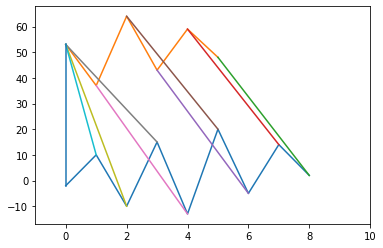

In [259]:
# Test sur exos de TD
A=np.array([-2,10,-10,15,-13,20,-5,14,2])
B=np.array([3,-13,14,-7,9,-2])

cost, path = DTW(A, B, window = max(len(A),len(B)))
print('Score DTW entre les 2 séquences : ', cost)
print('Path : ', path)
    
offset = 50
plt.xlim([-1, max(len(A), len(B)) + 1])
plt.plot(A)
plt.plot(B+offset)
for (x1, x2) in path:
    plt.plot([x1, x2], [A[x1], B[x2] + offset])
plt.show()

# Partie II : Système de reconnaissance d'activité physique avec la DTW



Pour chaque profil temporel test,
- Calculer pour chaque classe, le score de la DTW entre le profil temporel test et les profils temporels de la classe 
- Déterminer la classe d'appartenance par minimum du score sur toutes les classes



In [260]:
# Système de reconnaissance à partir de la DTW
def ApprentissageDTW(tailleTest, nbClasses, dataconvoluted, ListDataTest, LabelTest, profilmoyen, w=[1,1,1]): 
    #print('Dimension profilMoyen : ', profilmoyen.shape)
    #print('Dimension dataconvoluted : ', dataconvoluted.shape)
    #print('dataconvoluted : \n', dataconvoluted)
    #print('ListDataTest : \n', ListDataTest)
    #print(tailleTest*nbClasses)
    PartitionDTW=np.zeros((tailleTest*nbClasses,2))
    
    for num in range(tailleTest*nbClasses):
        result=np.zeros(nbClasses)
        # On effectue DTW sur chacun des profils moyen(représentant chaque classe) et on l'associe à la classe qui a 
        # le cout minimum
        for i in range(nbClasses):
            val=int(ListDataTest[num])
            # A généraliser pour d'autres profils d'activité de la base 
            # d'apprentissage (pas seulement le profil moyen)
            cost,path =DTW(dataconvoluted[val,:,:],profilmoyen[i,:,:],w=w)
            result[i]=cost
            index=np.argmin(result)
            PartitionDTW[num,0]=index
            PartitionDTW[num,1]=LabelTest[num]
            
    return PartitionDTW 


In [261]:
PartitionDTW = ApprentissageDTW(TAILLE_TEST, N_CLASSES, data_convoluted, List_Data_Test, Label_Test, profil_moyen)

## Evaluation des résultats de la DTW

A partir de la partition de l'ensemble test obtenue après la DTW, calculer la matrice de confusion qui recense le nombre de données bien classés et mal classés.

Matrice de confusion par DTW
Accuracy sur base de test : 0.5


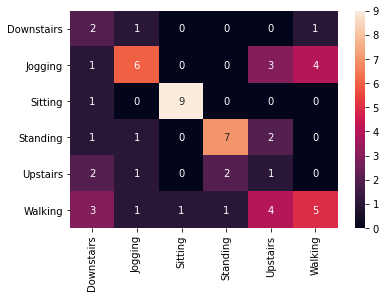

In [262]:
# Evaluation des résultats par matrices de confusion 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print('Matrice de confusion par DTW')
cm=confusion_matrix(PartitionDTW[:,0],PartitionDTW[:,1])
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS),yticklabels=np.unique(LABELS),annot=True)

# score de performance
print('Accuracy sur base de test :',accuracy_score(PartitionDTW[:,0],PartitionDTW[:,1]))

# Partie III : Comparaison de la programmation dynamique avec une méthode de classification après prétraitement des données

Dans cette partie, nous allons comparer les résultats de la DTW avec ceux d'une méthode de classification de données : les k-plus proches voisins.

Nous utiliserons les fonctions permettant de calculer l'ACP et les kppv via la librairie python *scikit-learn*.





In [263]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D

### Prétraitement par ACP

Pour tester une autre méthode de classification, 

1. A partir des données Data_App de la base d'apprentissage et en utilisant la fonction *PCA* de la librairie *scikit-learn*, calculez les 3 axes principaux de l'ACP en
extrayant les 3 vecteurs propres, notés $X_1$, $X_2$, $X_3$, associés aux 3 plus grandes valeurs propres de la matrice de
variance-covariance $\Sigma_{App}$.Ces vecteurs propres constitueront la nouvelle base de données.

2. Projetez les données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque
vecteur par la base $P = [X_1X_2X_3]$.

*Remarque :* vous pouvez aussi implémenter l'ACP en
extrayant les 3 vecteurs propres, notés $X_1$, $X_2$, $X_3$, associés aux 3 plus grandes valeurs propres de la matrice de
variance-covariance $\Sigma_{App}$ (par les fonctions *np.cov* et *np.linalg.eig*). Ces vecteurs propres constitueront le nouveau repère P.  Projetez ensuite les données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque vecteur par la base $P = [X_1X_2X_3]$.




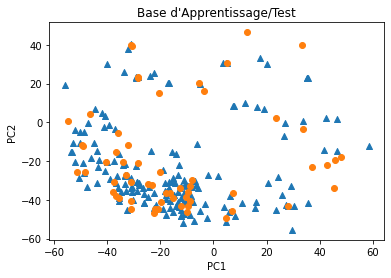

Contraste : 0.7107967650428852


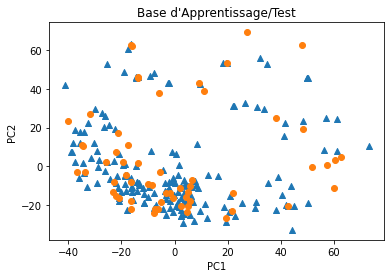

0.7107967650428851


In [264]:
from sklearn.decomposition import PCA

n_components=10

# En utilisant la méthode implémenté
T=np.transpose(Data_App)   
cov_mat=np.cov(np.transpose(Data_App))

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

principalAxes=np.zeros((Data_App.shape[1],n_components))

for i in range(n_components):
    principalAxes[:,i]=eig_vecs[:,i]

principalComponentsApp = Data_App.dot(principalAxes)
principalComponentsTest = Data_Test.dot(principalAxes)


# affichage des points
#for i in range(0,N_CLASSES*TAILLE_APP):
plt.scatter(principalComponentsApp[:, 0], principalComponentsApp[:, 1],marker='^')
plt.scatter(principalComponentsTest[:, 0], principalComponentsTest[:, 1],marker='o')
plt.title("Base d'Apprentissage/Test")
plt.xlabel("PC1")
plt.ylabel("PC2");
plt.show()

# Pourcentage d'information conservée
Contraste=sum(eig_vals[range(n_components)])/sum(eig_vals)
print("Contraste :", Contraste)



# En utilisant sklearn    
pca = PCA(n_components)
principalComponentsApp = pca.fit_transform(Data_App)
principalComponentsTest= pca.transform(Data_Test)

# affichage des points
plt.scatter(principalComponentsApp[:, 0], principalComponentsApp[:, 1],marker='^')
plt.scatter(principalComponentsTest[:, 0], principalComponentsTest[:, 1],marker='o')
plt.title("Base d'Apprentissage/Test")
plt.xlabel("PC1")
plt.ylabel("PC2");
plt.show()



# Conservation de l'information : Variance 
print(sum(pca.explained_variance_ratio_))

In [265]:
# Implémentation de l'ACP
def pretraitement_ACP(dataApp, dataTest, components):
    
    T=np.transpose(dataApp)   
    cov_mat=np.cov(np.transpose(dataApp))
    #print('Dimension dataApp : ', dataApp.shape)
    #print('Dimension dataTest : ', dataTest.shape)

    eig_vals, eig_vecs = np.linalg.eig(cov_mat)

    principalAxes=np.zeros((dataApp.shape[1],components))
    
    for i in range(components):
        principalAxes[:,i]=eig_vecs[:,i]

    principalComponentsApp = dataApp.dot(principalAxes)
    principalComponentsTest = dataTest.dot(principalAxes)
    
    return principalComponentsApp, principalComponentsTest


In [266]:
pcApp, pcTest = pretraitement_ACP(Data_App, Data_Test, n_components)

# Classification par k plus proches voisins

En intelligence artificielle, la méthode des k plus proches voisins (k-ppv) est une méthode d'apprentissage
supervisé. Dans ce cadre, on dispose d'une base de données d'apprentissage constituée de couples  "donnée-label". Pour estimer la sortie associée à une nouvelle entrée x, la méthode des k plus proches voisins consiste à prendre
en compte (de façon identique) les k échantillons d'apprentissage dont l'entrée est la plus proche de la nouvelle
entrée x, selon une distance à définir. L'algorithme 1 associé et un exemple (figure 1) sont données par la suite.

<img src="files/AlgoKppv.png" width="900" height="800"  >

<img src="files/kppv.png" width="300" height="300"  >

**Exemple de classification par k-ppv.** L'échantillon de test (cercle vert) doit être classé soit dans la première
classe des carrés bleus, soit dans la deuxième classe des triangles rouges. 
Si k = 3 (cercle plein), il est assigné à la deuxième classe parce qu'il y a 2 triangles et seulement 1 carré à l'intérieur du cercle intérieur. 
Si k = 5 (cercle en pointillés), il est assigné à la première classe (3 carrés contre 2 triangles à l'intérieur du cercle extérieur)


1. En utilisant la fonction *KNeighborsClassifier* de la librairie *sklearn.neighbors*, réalisez une classification par k-ppv sur la base d'apprentissage et la base de test que vous avez prédéfinies (prendre $k=1$).

2. Evaluez la méthode des k-ppv par le calcul de la matrice de confusion et du taux de reconnaissance.

3. Modifiez la valeur de $k$ pour les k-ppv. Améliorez-vous les scores de reconnaissance ?

4. Comparez vos résultats avec ceux de la DTW.




Matrice de confusion avec ACP+kNN
Accuracy sur base de test : 0.38333333333333336


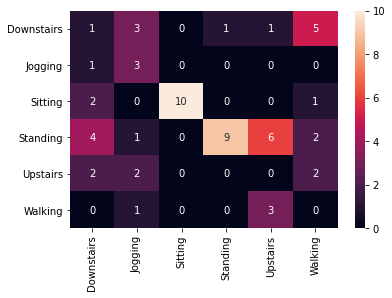

In [267]:
error=[]


knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(pcApp, Label_App)
pred_i = knn.predict(pcTest)

# Evaluation des résultats par matrices de confusion 
print('Matrice de confusion avec ACP+kNN')
cm=confusion_matrix(pred_i,Label_Test)
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS),yticklabels=np.unique(LABELS),annot=True)

# score de performance
print('Accuracy sur base de test :',accuracy_score(pred_i,Label_Test))


**Conclusion :** voir page 2

# Partie IV : Votre étude

Réalisez votre propre étude en :
- en Augmentant les bases de test et/ou d'apprentissage et/ou la durée des segments 
- en proposant des variantes (changement de norme pour la DTW, pondération différente pour les wi, contrainte locale, testez avec davantage de vecteurs propres pour l'ACP (utiliser le contraste)...)
- en rajoutant davantage de classes (jusqu'à 3 supplémentaires : 4-Debout, 5-Monter ou 6-Marcher ) 
le tout en testant les deux approches et en interprétant les résultats, à synthétiser sur un rapport. 


In [268]:
import warnings
warnings.filterwarnings('ignore')

Nous avons choisis de garder le même découpage que dans le rapport, vous retrouverez donc les grands titres. 

## **1. Evaluation des résultats initiaux**

Cette partie est une analyser des résultats précédents, vous pouvez la retrouver dans le rapport. 

En revanche, comme précisé, nous avons créer différentes fonctions pour faciliter l'exécution. 
Les trois fonctions suivantes en sont des exemples. 

In [269]:
# Quelques fonctions utiles

"""
Fonction qui effectue le test de classification avec la DTW 
    et affiche le score de précision et la matrice de confusion
"""
def fitDTW(NbClasses, tailleTest, data_convoluted, List_Data_Test, Label_Test, profil_moyen, w=[1,1,1]): 
    PartitionDTW = ApprentissageDTW(tailleTest, NbClasses, data_convoluted, List_Data_Test, Label_Test, profil_moyen, w) 
    
    cm=confusion_matrix(PartitionDTW[:,0],PartitionDTW[:,1])
    sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS),yticklabels=np.unique(LABELS),annot=True)

    # score de performance
    accuracy = accuracy_score(PartitionDTW[:,0],PartitionDTW[:,1]) 
    print('Accuracy sur base de test :', accuracy)
    
    return accuracy

"""
Fonction qui effectue le test de classification avec le classifieur KPPV 
    et affiche le score de précision et la matrice de confusion
"""
def fitKPPV(NbClasses, pcApp, pcTest, Label_Test, nb_voisins):
    knn = KNeighborsClassifier(n_neighbors=nb_voisins)
    knn.fit(pcApp, Label_App)
    pred_i = knn.predict(pcTest)

    # Evaluation des résultats par matrices de confusion 
    cm=confusion_matrix(pred_i,Label_Test)
    sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS[0:NbClasses]),yticklabels=np.unique(LABELS[0:NbClasses]),annot=True)

    # score de performance
    print('Accuracy sur base de test :',accuracy_score(pred_i,Label_Test))
    
"""
Fonction qui tire crée un nouveau jeu de données d'apprentissage 
    et de test et effectue un prétraitement ACP
"""
def pretraitement_ACP_base(NbClasses, segmentTimeSize, timeStep, nFeatures, tailleTest, tailleApp, components):
    Label_App, Data_Test, Data_App, data_convoluted, profil_moyen, List_Data_Test, Label_Test, labels = base(NbClasses, segmentTimeSize, timeStep, nFeatures, tailleTest, tailleApp)
    pcApp, pcTest = pretraitement_ACP(Data_App, Data_Test, components)
    return pcApp, pcTest, Label_App, Label_Test


## **1. Résultats obtenus avec des changements sur les bases de tests, d'apprentissage et/ou de la durée des segments**

**Avec une base d'apprentissage avec peu de données :**

In [236]:
# Durée des profils temporels
TIME_STEP = 30
SEGMENT_TIME_SIZE = 30

# Paramètres
N_CLASSES = 6
N_FEATURES = 3

In [237]:
TAILLE_TEST = 10
TAILLE_APP = 10

---------------- Avec une base d'apprentissage avec peu de données ----------------

### DTW ###
Accuracy sur base de test : 0.4666666666666667

### KPPV ###
Accuracy sur base de test : 0.36666666666666664


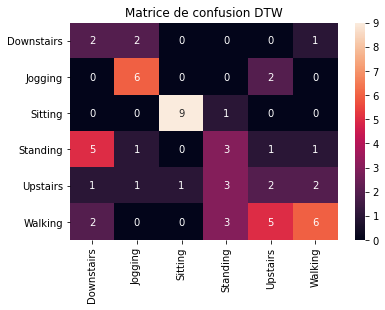

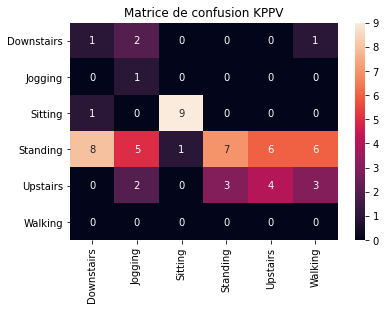

In [238]:
Label_App, Data_Test, Data_App, data_convoluted, profil_moyen, List_Data_Test, Label_Test, labels = base(N_CLASSES, SEGMENT_TIME_SIZE, TIME_STEP, N_FEATURES, TAILLE_TEST, TAILLE_APP)

print("---------------- Avec une base d'apprentissage avec peu de données ----------------")
print() 

print("### DTW ###")
plt.figure()
plt.title("Matrice de confusion DTW")
fitDTW(N_CLASSES, TAILLE_TEST, data_convoluted, List_Data_Test, Label_Test, profil_moyen)

print("\n### KPPV ###")
plt.figure()
plt.title("Matrice de confusion KPPV")
pcApp, pcTest = pretraitement_ACP(Data_App, Data_Test, components=10)
fitKPPV(N_CLASSES, pcApp, pcTest, Label_Test, nb_voisins=3)


**Avec une base de test très grande :** 

In [38]:
TAILLE_TEST=200
TAILLE_APP=10  

---------------- Avec une base de test très grande ----------------

### DTW ###
Matrice de confusion par DTW
Accuracy sur base de test : 0.4841666666666667

### KPPV ###
Matrice de confusion avec ACP+kNN
Accuracy sur base de test : 0.37666666666666665


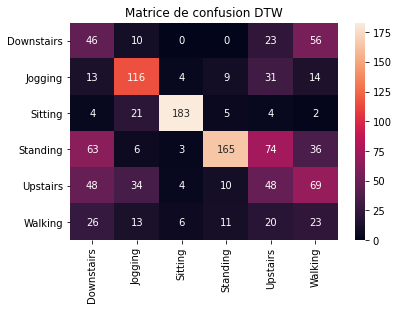

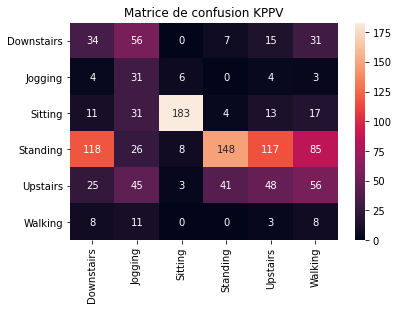

In [39]:
Label_App, Data_Test, Data_App, data_convoluted, profil_moyen, List_Data_Test, Label_Test, labels = base(N_CLASSES, SEGMENT_TIME_SIZE, TIME_STEP, N_FEATURES, TAILLE_TEST, TAILLE_APP)


print("---------------- Avec une base de test très grande ----------------")
print() 

print("### DTW ###")
plt.figure()
plt.title("Matrice de confusion DTW")
fitDTW(N_CLASSES, TAILLE_TEST, data_convoluted, List_Data_Test, Label_Test, profil_moyen)

print("\n### KPPV ###")
plt.figure()
plt.title("Matrice de confusion KPPV")
pcApp, pcTest = pretraitement_ACP(Data_App, Data_Test, components=10)
fitKPPV(N_CLASSES, pcApp, pcTest, Label_Test, nb_voisins=3)

**Avec une base d'apprentissage plus grande :** 

In [239]:
TAILLE_TEST=100
TAILLE_APP=1000 

---------------- Avec une base d'apprentissage plus grande ----------------

### DTW ###
Accuracy sur base de test : 0.49

### KPPV ###
Accuracy sur base de test : 0.8216666666666667


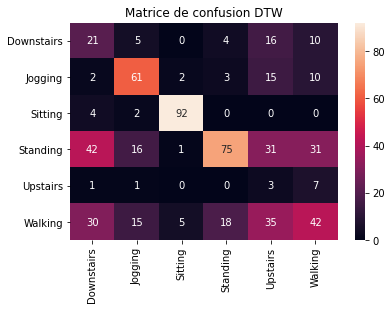

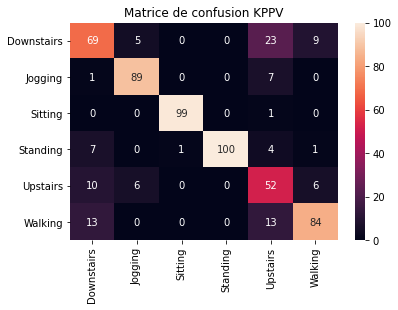

In [240]:
Label_App, Data_Test, Data_App, data_convoluted, profil_moyen, List_Data_Test, Label_Test, labels = base(N_CLASSES, SEGMENT_TIME_SIZE, TIME_STEP, N_FEATURES, TAILLE_TEST, TAILLE_APP)


print("---------------- Avec une base d'apprentissage plus grande ----------------")
print() 

print("### DTW ###")
plt.figure()
plt.title("Matrice de confusion DTW")
fitDTW(N_CLASSES, TAILLE_TEST, data_convoluted, List_Data_Test, Label_Test, profil_moyen)

print("\n### KPPV ###")
plt.figure()
plt.title("Matrice de confusion KPPV")
pcApp, pcTest = pretraitement_ACP(Data_App, Data_Test, components=10)
fitKPPV(N_CLASSES, pcApp, pcTest, Label_Test, nb_voisins=3)

**Avec une durée de segments plus petite :** 

In [42]:
TAILLE_TEST=100
TAILLE_APP=500
TIME_STEP = 10
SEGMENT_TIME_SIZE = 10

Label_App, Data_Test, Data_App, data_convoluted, profil_moyen, List_Data_Test, Label_Test, labels = base(N_CLASSES, SEGMENT_TIME_SIZE, TIME_STEP, N_FEATURES, TAILLE_TEST, TAILLE_APP)

---------------- Avec une durée de segements plus petite ----------------

### DTW ###
Matrice de confusion par DTW
Accuracy sur base de test : 0.47

### KPPV ###
Matrice de confusion avec ACP+kNN
Accuracy sur base de test : 0.715


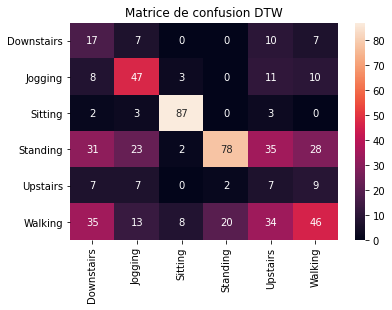

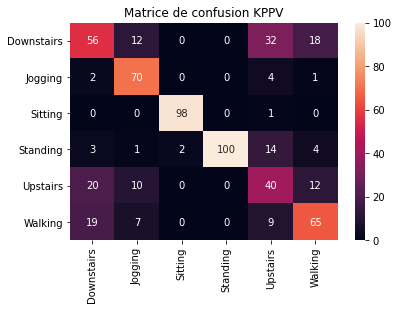

In [43]:

print("---------------- Avec une durée de segements plus petite ----------------")
print() 

print("### DTW ###")
plt.figure()
plt.title("Matrice de confusion DTW")
fitDTW(N_CLASSES, TAILLE_TEST, data_convoluted, List_Data_Test, Label_Test, profil_moyen)

print("\n### KPPV ###")
plt.figure()
plt.title("Matrice de confusion KPPV")
pcApp, pcTest = pretraitement_ACP(Data_App, Data_Test, components=10)
fitKPPV(N_CLASSES, pcApp, pcTest, Label_Test, nb_voisins=3)

**Avec une durée de segments plus grande :** 

In [44]:
TIME_STEP = 100
SEGMENT_TIME_SIZE = 100

Label_App, Data_Test, Data_App, data_convoluted, profil_moyen, List_Data_Test, Label_Test, labels = base(N_CLASSES, SEGMENT_TIME_SIZE, TIME_STEP, N_FEATURES, TAILLE_TEST, TAILLE_APP)

---------------- Avec une durée de segment plus grande ----------------

### DTW ###
Matrice de confusion par DTW
Accuracy sur base de test : 0.49

### KPPV ###
Matrice de confusion avec ACP+kNN
Accuracy sur base de test : 0.7566666666666667


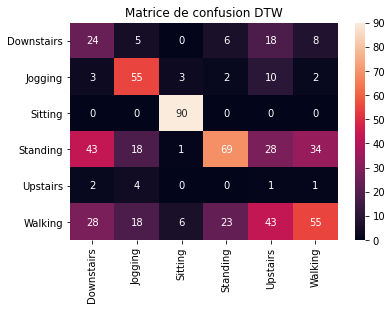

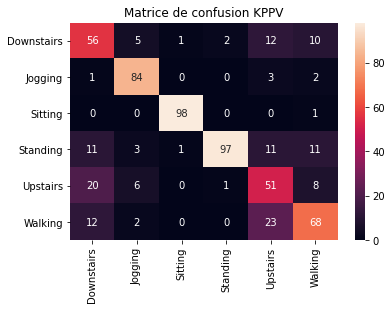

In [45]:

print("---------------- Avec une durée de segment plus grande ----------------")
print() 

print("### DTW ###")
plt.figure()
plt.title("Matrice de confusion DTW")
fitDTW(N_CLASSES, TAILLE_TEST, data_convoluted, List_Data_Test, Label_Test, profil_moyen)

print("\n### KPPV ###")
plt.figure()
plt.title("Matrice de confusion KPPV")
pcApp, pcTest = pretraitement_ACP(Data_App, Data_Test, components=10)
fitKPPV(N_CLASSES, pcApp, pcTest, Label_Test, nb_voisins=3)

**Conclusion :** voir pages 2-4 

## 3. Résultats obtenus en modifiant le nombre de classes


In [287]:
# Durée des profils temporels
TIME_STEP = 60

# Paramètres
N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration
SEGMENT_TIME_SIZE = 30
TAILLE_TEST=50
TAILLE_APP=150 

**Avec deux classes** 

In [48]:
N_CLASSES = 2

Label_App, Data_Test, Data_App, data_convoluted, profil_moyen, List_Data_Test, Label_Test, labels = base(N_CLASSES, SEGMENT_TIME_SIZE, TIME_STEP, N_FEATURES, TAILLE_TEST, TAILLE_APP)

---------------- Avec deux classes : 'Downstairs' et 'Jogging' ----------------

### DTW ###
Matrice de confusion par DTW
Accuracy sur base de test : 0.75

### KPPV ###
Matrice de confusion avec ACP+kNN
Accuracy sur base de test : 0.93


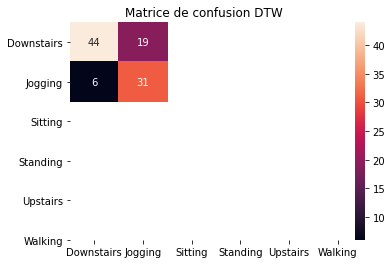

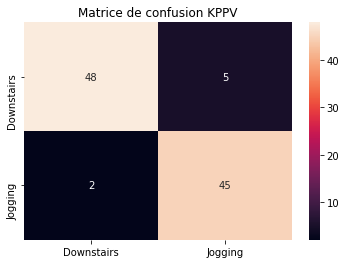

In [49]:

print("---------------- Avec deux classes : 'Downstairs' et 'Jogging' ----------------")
print() 

print("### DTW ###")
plt.figure()
plt.title("Matrice de confusion DTW")
fitDTW(N_CLASSES, TAILLE_TEST, data_convoluted, List_Data_Test, Label_Test, profil_moyen)

print("\n### KPPV ###")
plt.figure()
plt.title("Matrice de confusion KPPV")
pcApp, pcTest = pretraitement_ACP(Data_App, Data_Test, components=10)
fitKPPV(N_CLASSES, pcApp, pcTest, Label_Test, nb_voisins=3)

**Avec deux classes mais 'Jogging' et 'Sitting'** 

In [288]:
LABELS = [
    'Jogging',
    'Sitting',
    'Downstairs',
    'Standing',
    'Upstairs',
    'Walking'
]

In [297]:
N_CLASSES = 2

Label_App, Data_Test, Data_App, data_convoluted, profil_moyen, List_Data_Test, Label_Test, labels = base(N_CLASSES, SEGMENT_TIME_SIZE, TIME_STEP, N_FEATURES, TAILLE_TEST, TAILLE_APP)

---------------- Avec deux classes : 'Jogging' et 'Sitting' ----------------

### DTW ###
Accuracy sur base de test : 0.96

### KPPV ###
Accuracy sur base de test : 0.98


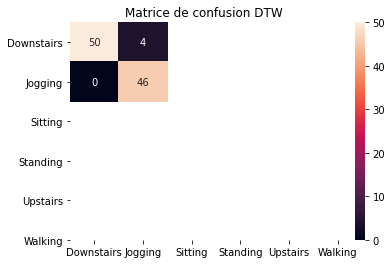

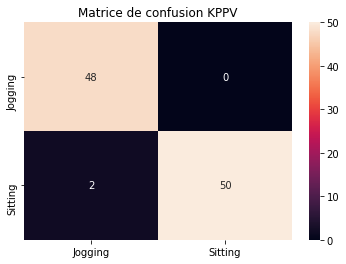

In [298]:

print("---------------- Avec deux classes : 'Jogging' et 'Sitting' ----------------")
print() 

print("### DTW ###")
plt.figure()
plt.title("Matrice de confusion DTW")
fitDTW(N_CLASSES, TAILLE_TEST, data_convoluted, List_Data_Test, Label_Test, profil_moyen)

print("\n### KPPV ###")
plt.figure()
plt.title("Matrice de confusion KPPV")
pcApp, pcTest = pretraitement_ACP(Data_App, Data_Test, components=10)
fitKPPV(N_CLASSES, pcApp, pcTest, Label_Test, nb_voisins=3)

**Avec 4 classes**

In [53]:
LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]

In [54]:
N_CLASSES = 4

Label_App, Data_Test, Data_App, data_convoluted, profil_moyen, List_Data_Test, Label_Test, labels = base(N_CLASSES, SEGMENT_TIME_SIZE, TIME_STEP, N_FEATURES, TAILLE_TEST, TAILLE_APP)

---------------- Avec quatres classes : 'Downstairs', 'Jogging', 'Sitting' et 'Standing' ----------------

### DTW ###
Matrice de confusion par DTW
Accuracy sur base de test : 0.685

### KPPV ###
Matrice de confusion avec ACP+kNN
Accuracy sur base de test : 0.78


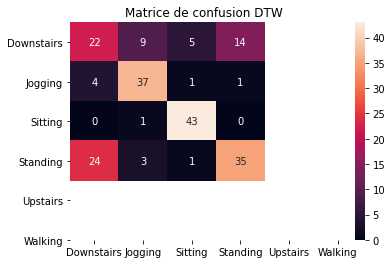

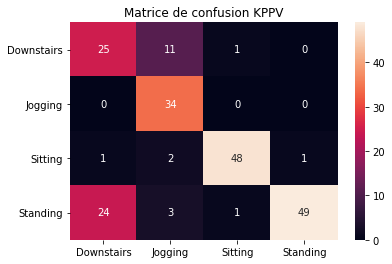

In [55]:
print("---------------- Avec quatres classes : 'Downstairs', 'Jogging', 'Sitting' et 'Standing' ----------------")
print()

print("### DTW ###")
plt.figure()
plt.title("Matrice de confusion DTW")
fitDTW(N_CLASSES, TAILLE_TEST, data_convoluted, List_Data_Test, Label_Test, profil_moyen)

print("\n### KPPV ###")
plt.figure()
plt.title("Matrice de confusion KPPV")
pcApp, pcTest = pretraitement_ACP(Data_App, Data_Test, components=10)
fitKPPV(N_CLASSES, pcApp, pcTest, Label_Test, nb_voisins=3)

**Avec 6 classes** 

In [56]:
N_CLASSES = 6

Label_App, Data_Test, Data_App, data_convoluted, profil_moyen, List_Data_Test, Label_Test, labels = base(N_CLASSES, SEGMENT_TIME_SIZE, TIME_STEP, N_FEATURES, TAILLE_TEST, TAILLE_APP)

---------------- Avec six classes : 'Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs' et 'Walking' ----------------

### DTW ###
Matrice de confusion par DTW
Accuracy sur base de test : 0.4766666666666667

### KPPV ###
Matrice de confusion avec ACP+kNN
Accuracy sur base de test : 0.69


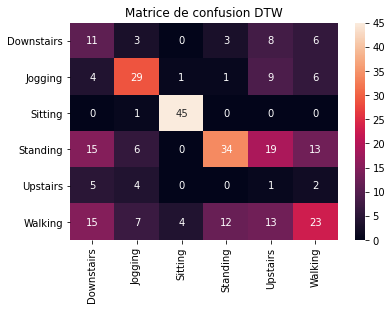

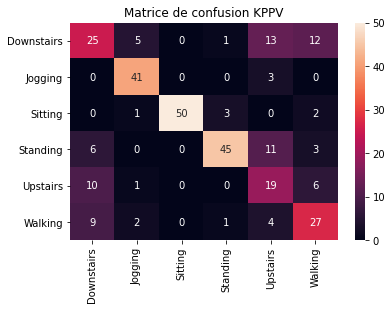

In [57]:
print("---------------- Avec six classes : 'Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs' et 'Walking' ----------------")
print()

print("### DTW ###")
plt.figure()
plt.title("Matrice de confusion DTW")
fitDTW(N_CLASSES, TAILLE_TEST, data_convoluted, List_Data_Test, Label_Test, profil_moyen)

print("\n### KPPV ###")
plt.figure()
plt.title("Matrice de confusion KPPV")
pcApp, pcTest = pretraitement_ACP(Data_App, Data_Test, components=10)
fitKPPV(N_CLASSES, pcApp, pcTest, Label_Test, nb_voisins=3)

**Conclusion :** voir pages 4-5 

## **4. Changement de distance pour la DTW**

In [58]:
import scipy.spatial.distance as di 
import numpy as num 

In [59]:
# Durée des profils temporels
TIME_STEP = 60

# Paramètres
N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration
SEGMENT_TIME_SIZE = 30
TAILLE_TEST=50
TAILLE_APP=150 

In [60]:
Label_App, Data_Test, Data_App, data_convoluted, profil_moyen, List_Data_Test, Label_Test, labels = base(N_CLASSES, SEGMENT_TIME_SIZE, TIME_STEP, N_FEATURES, TAILLE_TEST, TAILLE_APP)

In [61]:
"""Fonction Apprentissage mais qui prend en paramètre la distance à prendre en compte"""
def ApprentissageDTWNorme(d, tailleTest, nbClasses, dataconvoluted, ListDataTest, LabelTest, profilmoyen, w=[1,1,1]): 
    #print('Dimension profilMoyen : ', profilmoyen.shape)
    #print('Dimension dataconvoluted : ', dataconvoluted.shape)
    #print('dataconvoluted : \n', dataconvoluted)
    #print('ListDataTest : \n', ListDataTest)
    #print(tailleTest*nbClasses)
    PartitionDTW=np.zeros((tailleTest*nbClasses,2))
    
    for num in range(tailleTest*nbClasses):
        result=np.zeros(nbClasses)
        # On effectue DTW sur chacun des profils moyen(représentant chaque classe) et on l'associe à la classe qui a 
        # le cout minimum
        for i in range(nbClasses):
            val=int(ListDataTest[num])
            # A généraliser pour d'autres profils d'activité de la base 
            # d'apprentissage (pas seulement le profil moyen)
            cost,path =DTWNorme(dataconvoluted[val,:,:],profilmoyen[i,:,:], d=d, w=w)
            result[i]=cost
            index=np.argmin(result)
            PartitionDTW[num,0]=index
            PartitionDTW[num,1]=LabelTest[num]
            
    return PartitionDTW 

"""Fonction pour la DTW mais avec notre calcul de distance, 
        quelques modifications ont dûes être faites pour supporter cdist de scipy """
def DTWNorme(A, B, window = sys.maxsize, d = lambda x,y: np.linalg.norm((x-y)), w=[1,1,1]):
    # create the cost matrix
    A= np.array(A)
    B= np.array(B)
    M= len(A)
    N= len(B)
    cost = np.ones((M, N))
    
    w1 = w[0]
    w2 = w[1]
    w3 = w[2]
    
    # initialize the first row and column
    """print('A : ', A[0])  
    print('A : ', A[0].reshape(1, -1))""" 
    
    cost[0, 0] = d(A[0].reshape(1, -1), B[0].reshape(1, -1))
    
    #print('Val dist : ', cost[0, 0]) 
    for i in range(1, M):
        cost[i, 0] = cost[i-1, 0] + d(A[i].reshape(1, -1), B[0].reshape(1, -1))
    
    for j in range(1, N):
        cost[0, j] = cost[0, j-1] + d(A[0].reshape(1, -1), B[j].reshape(1, -1))
    # fill in the rest of the matrix
    for i in range(1, M):
        for j in range(max(1, i - window), min(N, i + window)):
            choices = w2*cost[i - 1, j - 1], w1*cost[i, j-1], w3*cost[i-1, j]
            cost[i, j] = min(choices) + d(A[i].reshape(1, -1), B[j].reshape(1, -1))
    """print(cost) """ 
    # find the optimal path
    n, m = N - 1, M - 1
    path = []

    while (m, n) != (0, 0):
        path.append((m, n))
        m, n = min((m - 1, n), (m, n - 1), (m - 1, n - 1))
    
    path.append((0,0))
    return cost[-1, -1]/(N+M), path

---------------- Comparaison des résultats en changeant la distance dans la DTW ----------------

### DTW norme initiale : euclidienne ###
Matrice de confusion par DTW
Accuracy sur base de test : 0.47

### DTW norme euclidienne avec notre méthode ###
Accuracy sur base de test : 0.47

### DTW norme racine carrée euclidienne ###
Accuracy sur base de test : 0.5033333333333333

### DTW distance de Manhattan ###
Accuracy sur base de test : 0.43


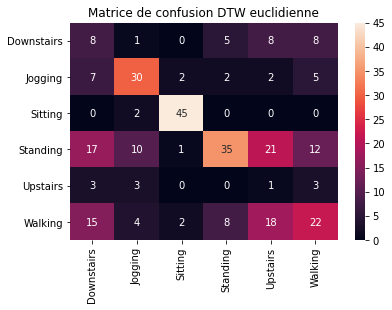

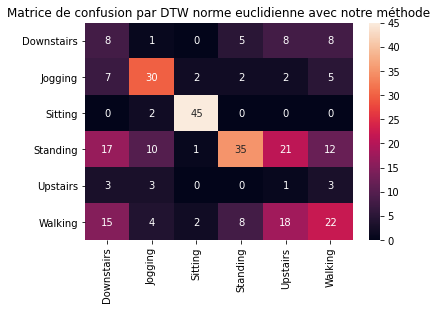

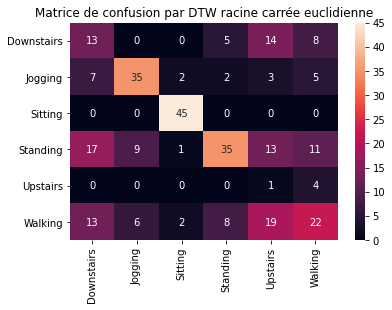

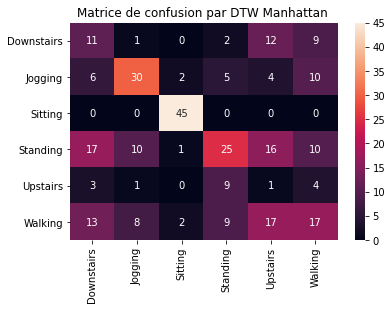

In [64]:
print("---------------- Comparaison des résultats en changeant la distance dans la DTW ----------------")
print()

print("### DTW norme initiale : euclidienne ###")
plt.figure()
plt.title("Matrice de confusion DTW euclidienne")
fitDTW(N_CLASSES, TAILLE_TEST, data_convoluted, List_Data_Test, Label_Test, profil_moyen)

print() 
print('### DTW norme euclidienne avec notre méthode ###') 

PartitionDTW = ApprentissageDTWNorme((lambda x,y: di.cdist(x, y, 'euclidean')), TAILLE_TEST, N_CLASSES, data_convoluted, List_Data_Test, Label_Test, profil_moyen)    
plt.figure()
plt.title('Matrice de confusion par DTW norme euclidienne avec notre méthode')
cm=confusion_matrix(PartitionDTW[:,0],PartitionDTW[:,1])
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS),yticklabels=np.unique(LABELS),annot=True)

# score de performance
print('Accuracy sur base de test :',accuracy_score(PartitionDTW[:,0],PartitionDTW[:,1]))

print() 
print('### DTW norme racine carrée euclidienne ###') 

PartitionDTW = ApprentissageDTWNorme((lambda x,y: di.cdist(x, y, 'sqeuclidean')), TAILLE_TEST, N_CLASSES, data_convoluted, List_Data_Test, Label_Test, profil_moyen)    
plt.figure() 
plt.title('Matrice de confusion par DTW racine carrée euclidienne')
cm=confusion_matrix(PartitionDTW[:,0],PartitionDTW[:,1])
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS),yticklabels=np.unique(LABELS),annot=True)

# score de performance
print('Accuracy sur base de test :',accuracy_score(PartitionDTW[:,0],PartitionDTW[:,1]))

print() 
print('### DTW distance de Manhattan ###') 

PartitionDTW = ApprentissageDTWNorme((lambda x,y: di.cdist(x, y, 'cityblock')), TAILLE_TEST, N_CLASSES, data_convoluted, List_Data_Test, Label_Test, profil_moyen)    
plt.figure() 
plt.title('Matrice de confusion par DTW Manhattan ')
cm=confusion_matrix(PartitionDTW[:,0],PartitionDTW[:,1])
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS),yticklabels=np.unique(LABELS),annot=True)

# score de performance
print('Accuracy sur base de test :',accuracy_score(PartitionDTW[:,0],PartitionDTW[:,1]))

**Conclusion :** voir page 5

## **5. Autres méthodes de classifications** 

In [146]:
from sklearn.model_selection import GridSearchCV

In [147]:
import warnings
warnings.filterwarnings('ignore')

### 1) SVC classifieur 

In [177]:
from sklearn import svm
from sklearn import preprocessing

In [178]:
TAILLE_TEST = 20 
TAILLE_APP = 30
COMPONENTS = 25
SEGMENT_TIME_SIZE = 30
TIME_STEP = 30

pcApp, pcTest, Label_App, Label_Test = pretraitement_ACP_base(N_CLASSES, SEGMENT_TIME_SIZE, TIME_STEP, N_FEATURES, TAILLE_TEST, TAILLE_APP, COMPONENTS)

---------------- Classifieur SVC ----------------

Accuracy sur base de test SVC: 0.6416666666666667
Paramètres utilisés :  {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


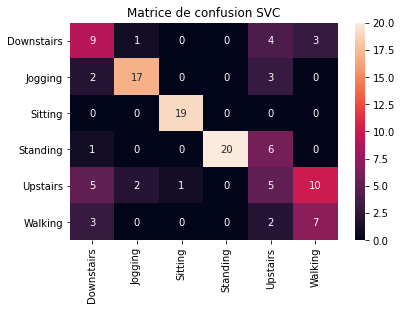

In [180]:
print("---------------- Classifieur SVC ----------------")
print()

clf = svm.SVC()

std_scale = preprocessing.StandardScaler().fit(pcApp)
pcApp_std = std_scale.transform(pcApp)
pcTest_std = std_scale.transform(pcTest)

pred_i = clf.fit(pcApp_std, Label_App).predict(pcTest_std)


# Evaluation des résultats par matrices de confusion 
cm=confusion_matrix(pred_i,Label_Test)
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS[0:N_CLASSES]),yticklabels=np.unique(LABELS[0:N_CLASSES]),annot=True)
plt.title('Matrice de confusion SVC')

# score de performance
print('Accuracy sur base de test SVC:',accuracy_score(pred_i,Label_Test))

print('Paramètres utilisés : ', clf.get_params())

In [197]:
param = [{'kernel': ['rbf', 'linear'], 'gamma': [1e-2], 'C': [0.1, 1, 10]}]

search = GridSearchCV(svm.SVC(), param, cv=5, n_jobs=-1)
search.fit(pcApp, Label_App)

best_para = search.best_params_

Accuracy sur base de test : 0.7083333333333334
Best parameters :  {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


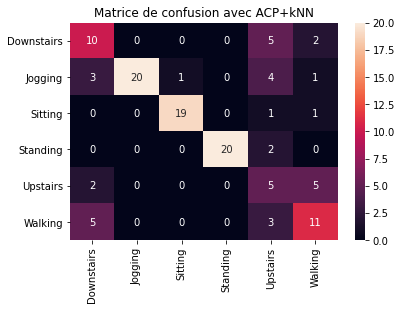

In [199]:
clf = svm.SVC(kernel='rbf', gamma=0.1, C=10)

std_scale = preprocessing.StandardScaler().fit(pcApp)
pcApp_std = std_scale.transform(pcApp)
pcTest_std = std_scale.transform(pcTest)

pred_i = clf.fit(pcApp_std, Label_App).predict(pcTest_std)


# Evaluation des résultats par matrices de confusion 
cm=confusion_matrix(pred_i,Label_Test)
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS[0:N_CLASSES]),yticklabels=np.unique(LABELS[0:N_CLASSES]),annot=True)
plt.title('Matrice de confusion avec ACP+kNN')

# score de performance
print('Accuracy sur base de test :',accuracy_score(pred_i,Label_Test))
print('Best parameters : ', best_para)

Chargement des données

In [148]:
TAILLE_TEST = 100
TAILLE_APP = 500
COMPONENTS = 25
SEGMENT_TIME_SIZE = 100
TIME_STEP = 100

In [149]:
pcApp, pcTest, Label_App, Label_Test = pretraitement_ACP_base(N_CLASSES, SEGMENT_TIME_SIZE, TIME_STEP, N_FEATURES, TAILLE_TEST, TAILLE_APP, COMPONENTS)

### 2) Classifieur Gaussien

In [156]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB

**Utilisation des paramètres par défaut :**

---------------- Classifieur Gaussien ----------------

Accuracy sur base de test : 0.6966666666666667
Paramètres utilisés :  {'priors': None, 'var_smoothing': 1e-09}


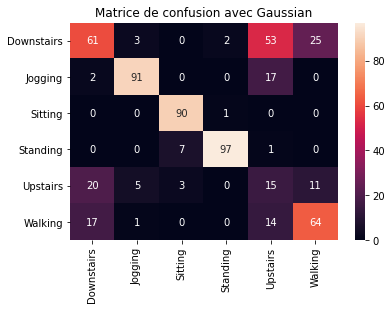

In [167]:
print("---------------- Classifieur Gaussien ----------------")
print()

clf = GaussianNB()
clf.fit(pcApp, Label_App)
pred_i = clf.predict(pcTest)

# Evaluation des résultats par matrices de confusion 
cm=confusion_matrix(pred_i,Label_Test)
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS[0:N_CLASSES]),yticklabels=np.unique(LABELS[0:N_CLASSES]),annot=True)
plt.title('Matrice de confusion avec Gaussian')

# score de performance
print('Accuracy sur base de test :',accuracy_score(pred_i,Label_Test))

print('Paramètres utilisés : ', clf.get_params())

**Recherche du paramètre optimal** 

In [168]:
param = [{'priors' : [None, [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]], 'var_smoothing' : [1e-9, 1e-3, 1e-4]}]

---------------- Classifieur Gaussien paramètres optimal ----------------

Accuracy sur base de test : 0.695
Best parameters :  {'priors': None, 'var_smoothing': 0.0001}


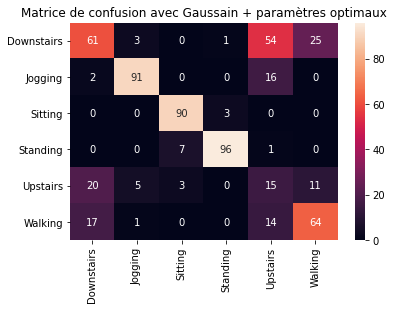

In [169]:
print("---------------- Classifieur Gaussien paramètres optimal ----------------")
print()

search = GridSearchCV(GaussianNB(), param) 
search.fit(pcApp, Label_App)

best_p = search.best_params_ 

pred_i = search.predict(pcTest)

# Evaluation des résultats par matrices de confusion 
cm=confusion_matrix(pred_i,Label_Test)
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS[0:N_CLASSES]),yticklabels=np.unique(LABELS[0:N_CLASSES]),annot=True)
plt.title("Matrice de confusion avec Gaussain + paramètres optimaux")

# score de performance
print('Accuracy sur base de test :',accuracy_score(pred_i,Label_Test))

print("Best parameters : ", best_p) 

### 3) Bernoulli classifieur 

**Avec les paramètres par défaut** 

---------------- Classifieur Bernoulli ----------------

Accuracy sur base de test : 0.49666666666666665
Paramètres :  {'alpha': 1.0, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True}


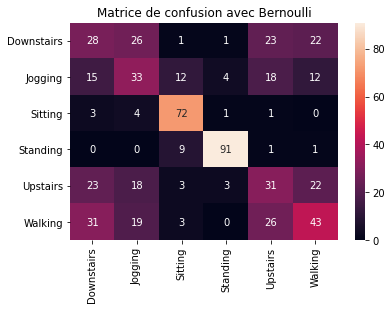

In [170]:
print("---------------- Classifieur Bernoulli ----------------")
print()

clf = BernoulliNB()
clf.fit(pcApp, Label_App)
pred_i = clf.predict(pcTest)

# Evaluation des résultats par matrices de confusion 
cm=confusion_matrix(pred_i,Label_Test)
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS[0:N_CLASSES]),yticklabels=np.unique(LABELS[0:N_CLASSES]),annot=True)
plt.title('Matrice de confusion avec Bernoulli')

# score de performance
print('Accuracy sur base de test :',accuracy_score(pred_i,Label_Test))

print('Paramètres : ', clf.get_params())

**Recherche du paramètre optimal** 

In [171]:
param = [{'alpha': [1e-1, 0.1, 0.2, 0.3, 0.5, 1.0, 1.2, 2.0, 4.0, 6.0, 10.0, 100.0, 1000.0], 'class_prior' : [None], 'binarize': [0.0, 0.1, 0.2, 0.5, 0.7, 1, 1.7, 2.0, 2.1, 2.2, 2.5, 3], 'fit_prior' : [True, False]}]

---------------- Classifieur Bernoulli avec paramètres optimaux ----------------

Accuracy sur base de test : 0.6066666666666667
Best parameters :  {'alpha': 0.1, 'binarize': 3, 'class_prior': None, 'fit_prior': True}


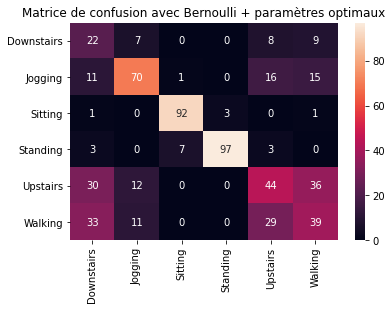

In [172]:
print("---------------- Classifieur Bernoulli avec paramètres optimaux ----------------")
print()

search = GridSearchCV(BernoulliNB(), param) 
search.fit(pcApp, Label_App)

best_p = search.best_params_ 

pred_i = search.predict(pcTest)

# Evaluation des résultats par matrices de confusion 
cm=confusion_matrix(pred_i,Label_Test)
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS[0:N_CLASSES]),yticklabels=np.unique(LABELS[0:N_CLASSES]),annot=True)
plt.title('Matrice de confusion avec Bernoulli + paramètres optimaux')

# score de performance
print('Accuracy sur base de test :',accuracy_score(pred_i,Label_Test))

print("Best parameters : ", best_p) 

### 4) Centroid classifieur 

In [173]:
from sklearn.neighbors import NearestCentroid

**Avec les paramètres par défaut**

---------------- Classifieur Centroid ----------------

Accuracy sur base de test : 0.3983333333333333
Paramètres :  {'metric': 'euclidean', 'shrink_threshold': None}


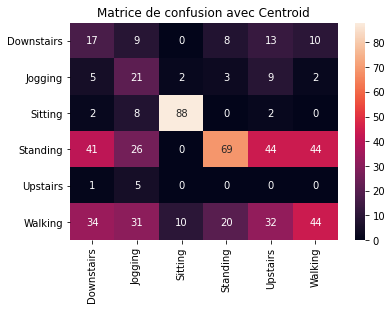

In [174]:
print("---------------- Classifieur Centroid ----------------")
print()

clf = NearestCentroid()
clf.fit(pcApp, Label_App)
pred_i = clf.predict(pcTest)

# Evaluation des résultats par matrices de confusion 
cm=confusion_matrix(pred_i,Label_Test)
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS[0:N_CLASSES]),yticklabels=np.unique(LABELS[0:N_CLASSES]),annot=True)
plt.title('Matrice de confusion avec Centroid')

# score de performance
print('Accuracy sur base de test :',accuracy_score(pred_i,Label_Test))

print('Paramètres : ', clf.get_params())

**Avec les paramètres optimaux** 

In [175]:
param = [{'metric' : ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan'], 'shrink_threshold' : [None, 0.1, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 5.0]}]

---------------- Classifieur Centroid avec paramètres optimaux ----------------

Accuracy sur base de test : 0.4166666666666667
Best parameters :  {'metric': 'manhattan', 'shrink_threshold': None}


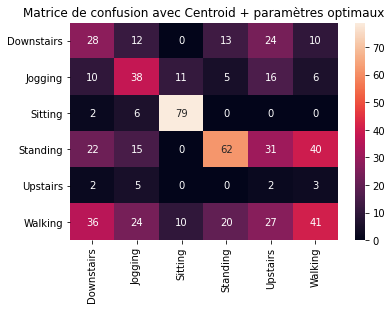

In [176]:
print("---------------- Classifieur Centroid avec paramètres optimaux ----------------")
print()

search = GridSearchCV(NearestCentroid(), param) 
search.fit(pcApp, Label_App)

best_p = search.best_params_ 

pred_i = search.predict(pcTest)

# Evaluation des résultats par matrices de confusion 
cm=confusion_matrix(pred_i,Label_Test)
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS[0:N_CLASSES]),yticklabels=np.unique(LABELS[0:N_CLASSES]),annot=True)
plt.title('Matrice de confusion avec Centroid + paramètres optimaux')

# score de performance
print('Accuracy sur base de test :',accuracy_score(pred_i,Label_Test))

print("Best parameters : ", best_p) 

### 5) Random Forest classifieur 

In [150]:
from sklearn.ensemble import RandomForestClassifier 

Avec les paramètres pas défaut

---------------- Classifieur Random Forest ----------------

Accuracy sur base de test : 0.8633333333333333
Paramètres :  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


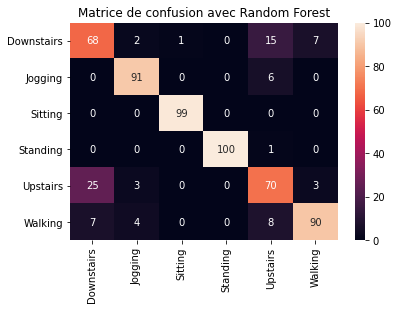

In [155]:
print("---------------- Classifieur Random Forest ----------------")
print()

clf = RandomForestClassifier()
clf.fit(pcApp, Label_App)
pred_i = clf.predict(pcTest)

# Evaluation des résultats par matrices de confusion 
cm=confusion_matrix(pred_i,Label_Test)
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS[0:N_CLASSES]),yticklabels=np.unique(LABELS[0:N_CLASSES]),annot=True)
plt.title('Matrice de confusion avec Random Forest')

# score de performance
print('Accuracy sur base de test :',accuracy_score(pred_i,Label_Test))

print('Paramètres : ', clf.get_params())

In [152]:
param = {
    'n_estimators' : [100], 
    'criterion' : ['gini', 'entropy'], 
    'max_depth' : [None], 
    'min_samples_split' : [2], 
    'min_samples_leaf' : [1], 
    'min_weight_fraction_leaf' : [0.0], 
    'max_features' : ['auto', 'sqrt', 'log2'], 
    'bootstrap' : [True, False], 
    'oob_score' : [True, False], 
    'class_weight' : [None, 'balanced', 'balanced_subsample'],     
}

---------------- Classifieur Random Forest avec paramètres optimaux ----------------

Accuracy sur base de test : 0.8666666666666667
Best parameters :  {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'oob_score': False}


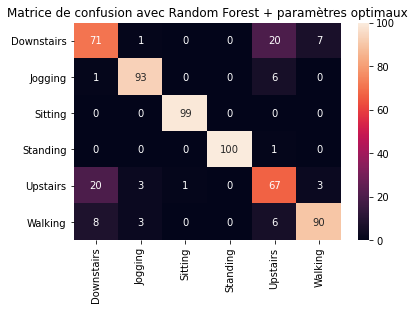

In [154]:
print("---------------- Classifieur Random Forest avec paramètres optimaux ----------------")
print()

search = GridSearchCV(RandomForestClassifier(), param) 
search.fit(pcApp, Label_App)

best_p = search.best_params_  

pred_i = search.predict(pcTest)

# Evaluation des résultats par matrices de confusion 
cm=confusion_matrix(pred_i,Label_Test)
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS[0:N_CLASSES]),yticklabels=np.unique(LABELS[0:N_CLASSES]),annot=True)
plt.title('Matrice de confusion avec Random Forest + paramètres optimaux')

# score de performance
print('Accuracy sur base de test :',accuracy_score(pred_i,Label_Test))

print("Best parameters : ", best_p) 


**Conclusion :** voir pages 5-8

## **6. Recherche des paramètres optimaux**


### 1) Nombre de composantes optimales du prétraitement ACP

In [276]:
"""Fonction qui trouve le nombre de composantes principales optimales"""
def best_param_acp(Data_App, Label_App, Data_Test, Label_Test, nbParam, nb_voisins):
    acc_best = 0
    comp_best = 0
    
    for i in range(1,nbParam):
        pcApp, pcTest = pretraitement_ACP(Data_App, Data_Test, i)

        knn = KNeighborsClassifier(n_neighbors=nb_voisins)
        knn.fit(pcApp, Label_App)
        pred_i = knn.predict(pcTest)
        acc_score = accuracy_score(pred_i,Label_Test)
        
        #print("nbComp = {}  -  accuracy_score = {}".format(i, acc_score))
        if acc_score > acc_best:
            acc_best = acc_score
            comp_best = i

    return comp_best


In [280]:
TAILLE_TEST = 100
TAILLE_APP = 500
SEGMENT_TIME_SIZE = 60
TIME_STEP = 60
N_CLASSES = 6 

nbParam = 60
nb_voisins = 3

---------------- Avec solution optimale ACP ----------------

### KPPV avec 3 vecteurs propres dans l'ACP ###
Accuracy sur base de test : 0.7433333333333333

Meilleur paramètre ACP :  17

### KPPV avec le nombre de vecteurs propres optimal dans l'ACP ###
Accuracy sur base de test : 0.7783333333333333


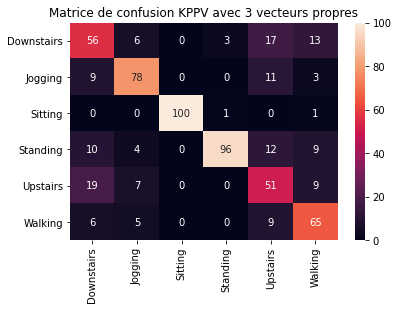

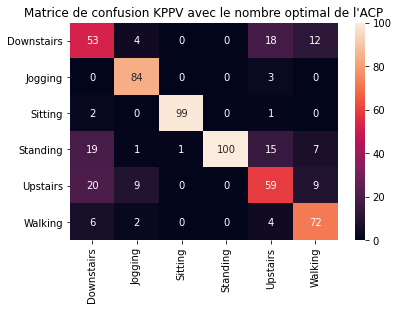

In [281]:
Label_App, Data_Test, Data_App, data_convoluted, profil_moyen, List_Data_Test, Label_Test, labels = base(N_CLASSES, SEGMENT_TIME_SIZE, TIME_STEP, N_FEATURES, TAILLE_TEST, TAILLE_APP)

print("---------------- Avec solution optimale ACP ----------------")
print()

print("### KPPV avec 3 vecteurs propres dans l'ACP ###")
pcApp, pcTest = pretraitement_ACP(Data_App, Data_Test, components=3)
plt.figure() 
plt.title("Matrice de confusion KPPV avec 3 vecteurs propres")
fitKPPV(N_CLASSES, pcApp, pcTest, Label_Test, nb_voisins=3)

best_comp = best_param_acp(Data_App, Label_App, Data_Test, Label_Test, nbParam, nb_voisins)

print("\nMeilleur paramètre ACP : ", best_comp)

print("\n### KPPV avec le nombre de vecteurs propres optimal dans l'ACP ###")
pcApp, pcTest = pretraitement_ACP(Data_App, Data_Test, components=best_comp)
plt.figure() 
plt.title("Matrice de confusion KPPV avec le nombre optimal de l'ACP")
fitKPPV(N_CLASSES, pcApp, pcTest, Label_Test, nb_voisins=3)


### 2) Nombre de voisins optimal pour KPPV

Recherche du nombre de voisins optimal à regarder pour la classification

In [282]:
from sklearn.model_selection import GridSearchCV

"""Fonction qui retourne le meilleurs nombre de voisins à utiliser"""
def best_param_knn(pcApp, Label_App, nb_voisins_max):
    # paramètres a tester
    param = [{"n_neighbors":list(range(1,nb_voisins_max))}]

    # création de la grille de recherche par cross-validation pour le classifieur kppv
    # (n_jobs == -1) pour effectuer le calcul sur tous les processeurs
    gsKnn = GridSearchCV(KNeighborsClassifier(), param, cv=5, n_jobs=-1)
    clf = gsKnn.fit(pcApp, Label_App)

    # paramètre optimal
    return clf.best_params_["n_neighbors"]
     

---------------- Avec solution optimale ACP et meilleur voisin ----------------


### KPPV avec 3 voisins sans optimisation avec amélioration de l'ACP ###
Accuracy sur base de test : 0.7783333333333333

Paramètre optimal classifieur kppv : 1

### KPPV avec le nombre de vecteurs propres optimal dans l'ACP et le meilleur nombre de voisins ###
Accuracy sur base de test : 0.84


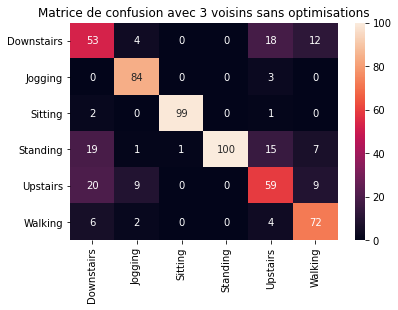

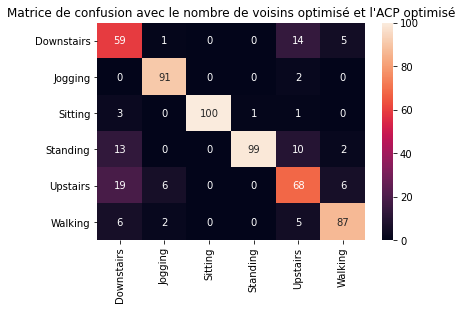

In [283]:
print("---------------- Avec solution optimale ACP et meilleur voisin ----------------")
print()

nb_voisins_max = 15

print("\n### KPPV avec 3 voisins sans optimisation avec amélioration de l'ACP ###")
fitKPPV(N_CLASSES, pcApp, pcTest, Label_Test, nb_voisins=3)
plt.title("Matrice de confusion avec 3 voisins sans optimisations")

best_knn_param = best_param_knn(pcApp, Label_App, nb_voisins_max)
print("\nParamètre optimal classifieur kppv :", best_knn_param)

print("\n### KPPV avec le nombre de vecteurs propres optimal dans l'ACP et le meilleur nombre de voisins ###")
plt.figure()
plt.title("Matrice de confusion avec le nombre de voisins optimisé et l'ACP optimisé")
fitKPPV(N_CLASSES, pcApp, pcTest, Label_Test, nb_voisins=best_knn_param)


### 3) Autres Classifieurs - Utilisation de GridSearchCV - Conclusion 

Pour voir la version optimal d'autres classifieurs, il faut aller dans la section "Autres classifieurs" qui est au dessus (chapitre 4). 

**Conclusion :** voir pages 6-8

## **7. Evaluation sur nos données**


In [304]:
LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking',
    'Roller'
]

axes = ['x', 'y', 'z']

ROLLER_COLUMN_NAMES = [
    'index',
    'x-axis',
    'y-axis',
    'z-axis'
]

NEW_DATA_PATH = "data/roller.txt"


# Durée des profils temporels
TIME_STEP = 60

# Paramètres
N_CLASSES = 7
N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration
SEGMENT_TIME_SIZE = 60
TAILLE_TEST=100
TAILLE_APP=500

In [305]:
# Lecture des nouvelles données
data_roller = pd.read_csv(NEW_DATA_PATH, delimiter=';')

# Coversion des données vers m/s²
for ax in axes:
    data_roller[ax] = data_roller[ax]*(-9.81)

# Formattage des données pour les associés aux données de base
data_roller['user'] = 1
data_roller['activity'] = 'Roller'
data_roller['timestamp'] = nan
del data_roller['index']
data_roller.rename(columns={"x": "x-axis", "y": "y-axis", "z": "z-axis"}, inplace=True)
data_roller = data_roller[['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']]

# Ajout des données au DataFrame contenant les données de base
data = pd.concat([data,data_roller], ignore_index=True)

# Création des bases d'apprentissage et de test
Label_App, Data_Test, Data_App, data_convoluted, profil_moyen, List_Data_Test, Label_Test, labels = base(N_CLASSES, SEGMENT_TIME_SIZE, TIME_STEP, N_FEATURES, TAILLE_TEST, TAILLE_APP)

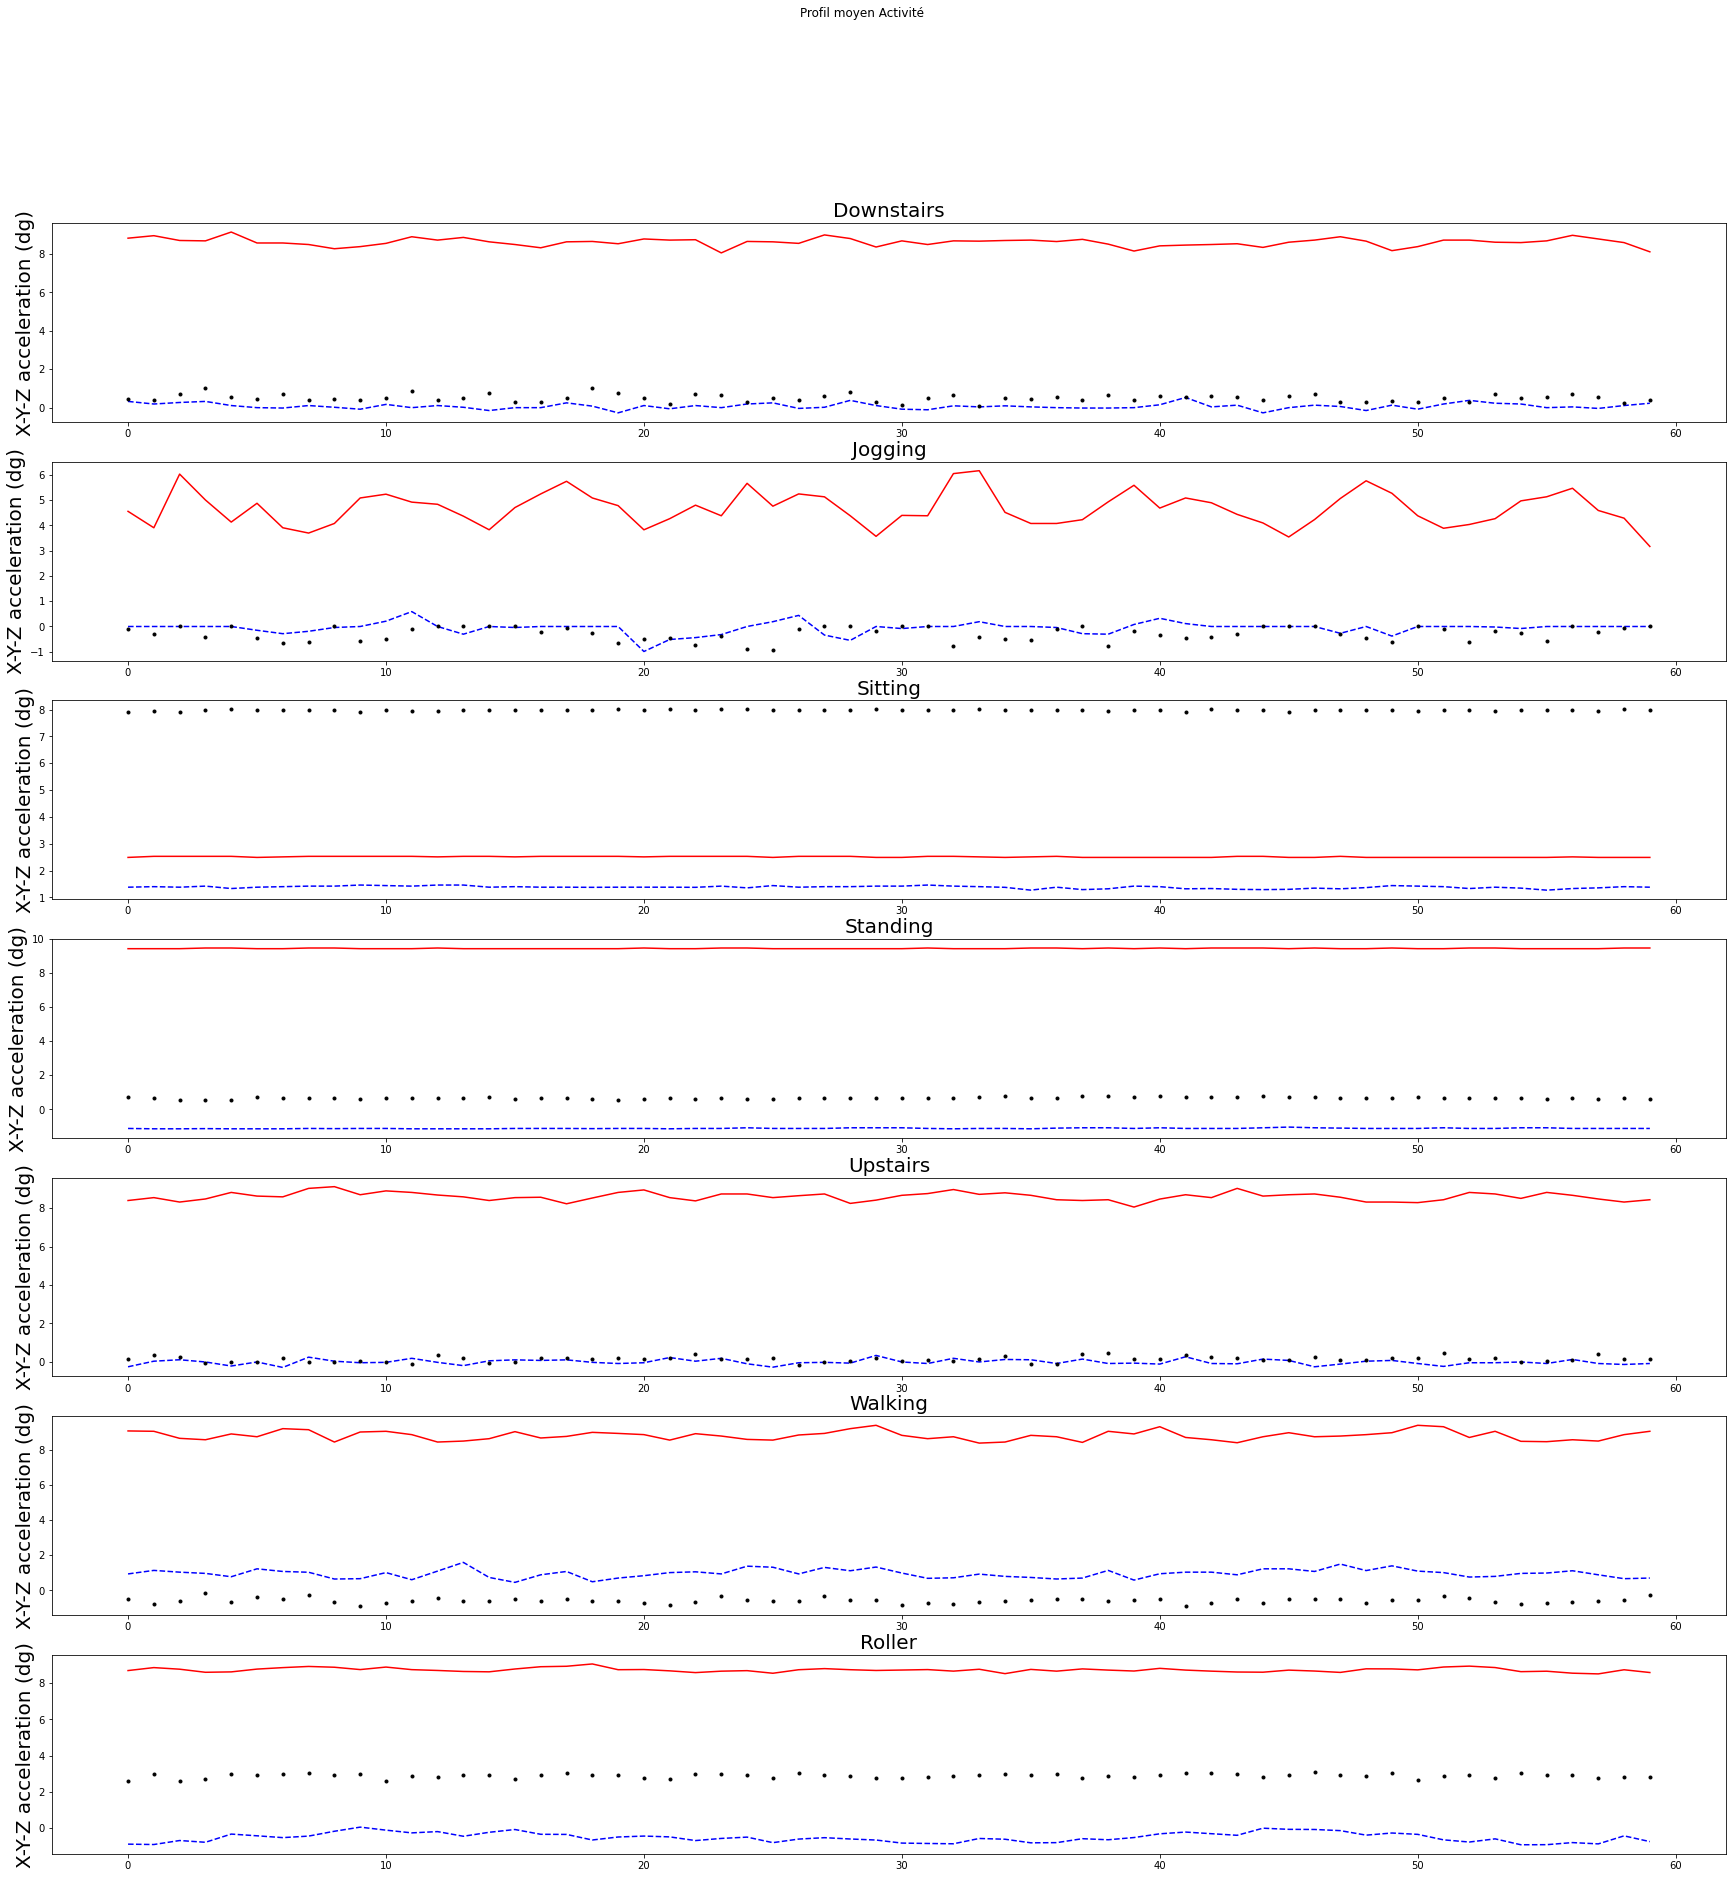

In [306]:
fig, axs = plt.subplots(N_CLASSES,figsize=(30,30))
fig.suptitle('Profil moyen Activité')
for i in range(N_CLASSES):
    class1 = profil_moyen[i,:,:]
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,0],'b--')
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,1],'r-')
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,2],'k.')
    axs[i].set_ylabel('X-Y-Z acceleration (dg)',fontsize=20)
    axs[i].set_title(LABELS[i], fontsize=20)

---------------- Avec nos données ----------------


Paramètre optimal classifieur kppv :  1

Nombre de composantes optimales ACP :  16

### KPPV avec le nombre de vecteurs propres optimal dans l'ACP ###
Accuracy sur base de test : 0.8485714285714285


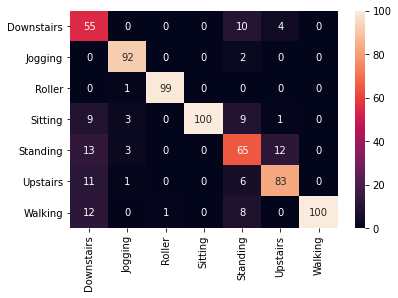

In [307]:
print("---------------- Avec nos données ----------------")
print()

# Recherche de meilleur paramètre
nbParam = 60
nb_voisins = 1
nb_voisins_max = 15
best_comp = best_param_acp(Data_App, Label_App, Data_Test, Label_Test, nbParam, nb_voisins)
pcApp, pcTest = pretraitement_ACP(Data_App, Data_Test, components=best_comp)
best_knn_param = best_param_knn(pcApp, Label_App, nb_voisins_max)
print("\nParamètre optimal classifieur kppv : ", best_knn_param)
print("\nNombre de composantes optimales ACP : ", best_comp)

print("\n### KPPV avec le nombre de vecteurs propres optimal dans l'ACP ###")
plt.figure()

fitKPPV(N_CLASSES, pcApp, pcTest, Label_Test, nb_voisins=best_knn_param)

### DTW ###
Accuracy sur base de test : 0.5057142857142857


0.5057142857142857

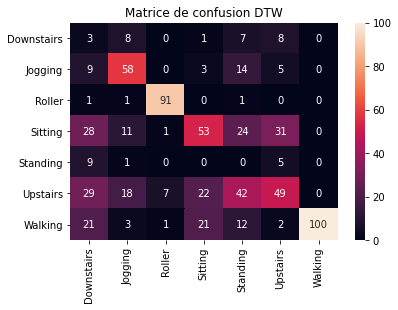

In [308]:
print("### DTW ###")
plt.figure()
plt.title("Matrice de confusion DTW")
fitDTW(N_CLASSES, TAILLE_TEST, data_convoluted, List_Data_Test, Label_Test, profil_moyen)

**Conclusion :** voir pages 8-9

## **8. Conclusion**


voir page 9 